In [42]:
# Make sure you have pymc3 installed
import sys
!{sys.executable} -m pip install pymc3

In [1]:
# make sure the notebook reloads the module each time we modify it
%load_ext autoreload
%autoreload 2

# make sure the displays are nice
%matplotlib inline
#figsize(12,8)

In [2]:
import parametric_regression as pr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")
import numpy as np
import pymc3 as pm

## Preparing data and utilities

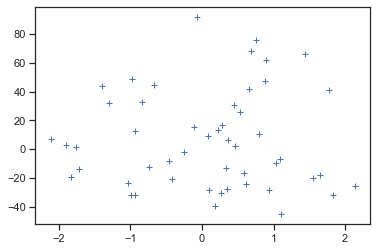

In [3]:
X, y, theta_true, sigma_noise, indices_support = pr.generate_data(sample_size = 50, dimension = 100, seed = 1)
plt.plot(X[:,8], y, '+')
plt.show()

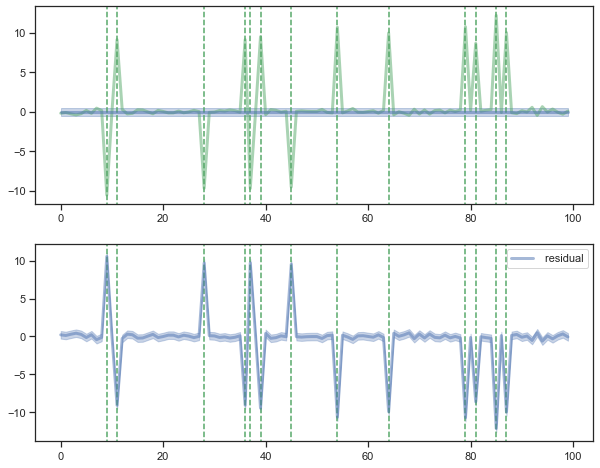

In [4]:
fake_std = .5*np.ones(theta_true.shape)
fake_theta_hat = np.zeros(theta_true.shape)
fig, ax = plt.subplots(2, figsize=(10,8))
pr.plot_coefficients(ax, theta_true=theta_true, indices_support=indices_support, theta_hat=fake_theta_hat, lower_bound=fake_theta_hat-fake_std, 
                     upper_bound=fake_theta_hat+fake_std)
plt.show()

## Using sklearn's lasso implementation as baseline

In [5]:
theta_lasso = pr.get_sklearn_lasso_estimate(X, y)
print(theta_lasso.shape)

(100,)


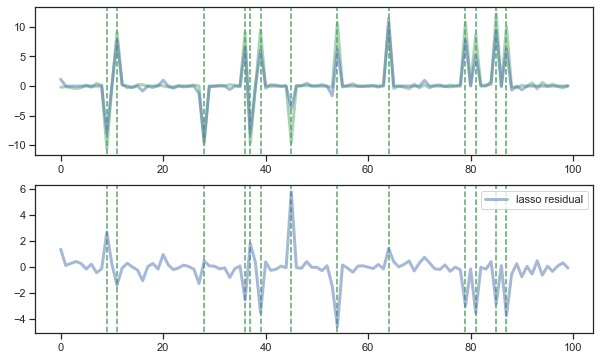

In [6]:
fig, ax = plt.subplots(2, figsize=(10,6))
pr.plot_coefficients(ax, theta_true=theta_true, indices_support=indices_support, theta_hat=theta_lasso, label="lasso")
plt.show()

## Bayesian lasso using a Laplace prior

In [7]:
trace = pr.get_mcmc_sample_for_laplace_prior(X, y)
accept = np.sum(trace['theta'][1:,0] != trace['theta'][:-1,0])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:38<00:00, 262.34draws/s]

Acceptance Rate:  0.999875


In [8]:
pm.summary(trace)

/Users/rbardenet/opt/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta__0,0.679217,1.132531,0.016819,-1.367998,3.103981,5154.736654,1.000015
theta__1,0.205036,0.891100,0.008873,-1.539386,2.125807,7742.001145,0.999874
theta__2,-0.057318,0.980995,0.010849,-2.064506,1.983917,7925.365405,0.999820
theta__3,0.018643,0.932320,0.009784,-1.967910,1.942256,9183.747368,1.000002
theta__4,-0.296381,0.944338,0.010087,-2.398107,1.452175,7171.441665,1.000166
...,...,...,...,...,...,...,...
theta__95,-0.909486,1.137522,0.012914,-3.347837,1.072313,6443.985458,0.999816
theta__96,1.022780,1.140055,0.015019,-1.019163,3.362508,5583.648278,1.000200
theta__97,0.061307,0.953106,0.009194,-1.971619,1.973812,9215.910914,0.999949
theta__98,0.301989,0.972725,0.011579,-1.599455,2.390402,8150.664989,1.000067


/Users/rbardenet/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


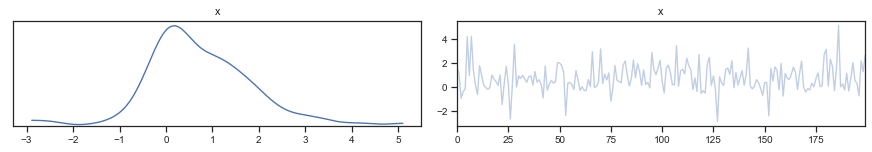

In [13]:
# Plot a trace and its running mean
pm.traceplot(trace["theta"][:2000:10,0], combined=False)
plt.show()

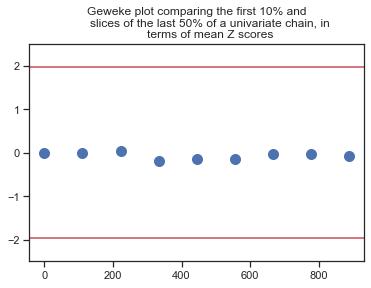

In [14]:
# Plot the Geweke diagnostic on theta_0 for the first chain
pr.plot_geweke(trace, 0, 0)

In [15]:
theta_laplace = trace.get_values('theta').mean(0) # not expected to show much sparsity
lower_bound_laplace = np.quantile(trace.get_values('theta'), 0.025, axis=0)
upper_bound_laplace = np.quantile(trace.get_values('theta'), 0.975, axis=0)

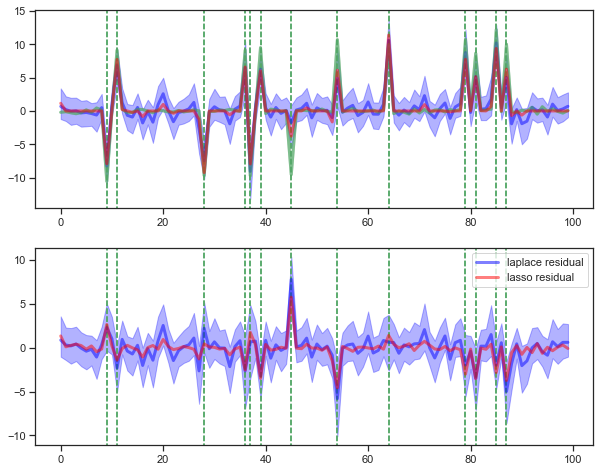

In [16]:
f, ax = plt.subplots(2, figsize=(10,8))
pr.plot_coefficients(ax, theta_true, indices_support=indices_support, theta_hat=theta_laplace, lower_bound=lower_bound_laplace, upper_bound=upper_bound_laplace,
             color="blue", label="laplace")
pr.plot_coefficients(ax, theta_true, indices_support=indices_support, theta_hat=theta_lasso, color="red", label="lasso")
plt.show()

The Laplace prior tends to overregularize. Can you get rid of that problem playing with the prior?

## Bayesian lasso using the horseshoe prior

In [17]:
trace_horseshoe = pr.get_mcmc_sample_for_horseshoe_prior(X, y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, lam, tau]
Sampling 4 chains: 100%|██████████| 6000/6000 [02:18<00:00, 43.32draws/s]
There were 297 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7506137783957788, but should be close to 0.9. Try to increase the number of tuning steps.
There were 178 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 190 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some para

In [58]:
pm.summary(trace_horseshoe)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta__0,-0.051094,0.292442,0.010155,-0.723016,0.525316,776.301722,1.003148
theta__1,0.135778,0.304984,0.010879,-0.400515,0.853088,777.996969,1.001334
theta__2,-0.148257,0.324905,0.011115,-0.950072,0.404069,846.623554,1.000926
theta__3,-0.070348,0.297794,0.010743,-0.734199,0.522969,755.793719,1.001349
theta__4,-0.113929,0.285631,0.010866,-0.758995,0.435368,667.463501,1.004132
...,...,...,...,...,...,...,...
lam__95,1.418941,3.649073,0.075665,0.002436,4.572529,2269.773484,0.999793
lam__96,1.052151,1.500546,0.029596,0.002768,3.234505,2704.160532,1.000345
lam__97,2.085685,3.701448,0.088058,0.004771,6.643747,1672.792892,1.001126
lam__98,1.190843,1.877690,0.040321,0.002833,3.933941,1918.776075,0.999985


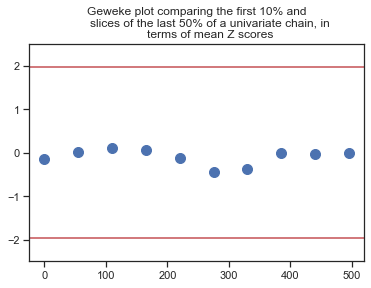

In [63]:
pr.plot_geweke(trace_horseshoe, 0, 0)

In [ ]:
theta_horseshoe = trace_horseshoe.get_values('theta').mean(0)
lower_bound_horseshoe = np.quantile(trace_horseshoe.get_values('theta'), 0.025, axis=0)
upper_bound_horseshoe = np.quantile(trace_horseshoe.get_values('theta'), 0.975, axis=0)

In [ ]:
f, ax = plt.subplots(2, figsize=(10,8))
pr.plot_coefficients(ax, theta_true, indices_support=indices_support, theta_hat=theta_laplace, lower_bound=lower_bound_laplace, upper_bound=upper_bound_laplace,
                     color="blue", label="laplace")
pr.plot_coefficients(ax, theta_true=theta_true, indices_support=indices_support, theta_hat=theta_horseshoe, lower_bound=lower_bound_horseshoe, 
                     upper_bound=upper_bound_horseshoe, color="orange", label="horseshoe")
#pr.plot_coefficients(theta_true, theta_lasso, color="red", label="lasso")

plt.show()

## Bayesian lasso using the Finnish horseshoe prior

In [ ]:
trace_finnish_horseshoe = pr.get_mcmc_sample_for_finnish_horseshoe_prior(X, y)

In [ ]:
theta_finnish_horseshoe = trace_finnish_horseshoe.get_values('theta').mean(0)
lower_bound_finnish_horseshoe = np.quantile(trace_finnish_horseshoe.get_values('theta'), 0.025, axis=0)
upper_bound_finnish_horseshoe = np.quantile(trace_finnish_horseshoe.get_values('theta'), 0.975, axis=0)

In [ ]:
f, ax = plt.subplots(2, figsize=(10,8))
pr.plot_coefficients(ax, theta_true, indices_support=indices_support, theta_hat=theta_laplace,
                     color="blue", label="laplace")
pr.plot_coefficients(ax, theta_true=theta_true, indices_support=indices_support, theta_hat=theta_horseshoe, lower_bound=lower_bound_horseshoe, 
                     upper_bound=upper_bound_horseshoe, color="orange", label="horseshoe")
pr.plot_coefficients(ax, theta_true, indices_support=indices_support, theta_hat=theta_finnish_horseshoe, lower_bound=lower_bound_finnish_horseshoe, 
                     upper_bound=upper_bound_finnish_horseshoe, color="magenta", label="finnish")
#pr.plot_coefficients(theta_true, theta_lasso, color="red", label="lasso")

plt.show()